In [1]:
import sys
sys.path.append("../")
import cv2
import os
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
from timm.data import create_transform
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np

from src.data.transforms import transforms_imagenet_eval

split = "val"
image_size = 384
data_dir = os.path.join("/edrive1/rchoudhu/ILSVRC2012", split)

val_transform = transforms_imagenet_eval(img_size=image_size, 
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
data_val = datasets.ImageFolder(
    root=f"{data_dir}",
    transform=val_transform
)

unnorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

/usr/local/anaconda3/envs/mixedres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from PIL import Image

def check_images_in_folder(image_path):
    # Get the containing folder
    folder_path = os.path.dirname(image_path)
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check if it's a file and has an image extension
        if os.path.isfile(file_path) and file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            try:
                with Image.open(file_path) as img:
                    img.verify()
                #print(f"Valid image: {filename}")
            except Exception as e:
                print(f"Corrupted image: {filename}, Error: {e}")

# Example usage
image_path = "/edrive1/rchoudhu/ILSVRC2012/train/n04037443/n04037443_4814.JPEG"
check_images_in_folder(image_path)


/tmp/ipykernel_1313852/3559367534.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img*255).astype(np.uint8)


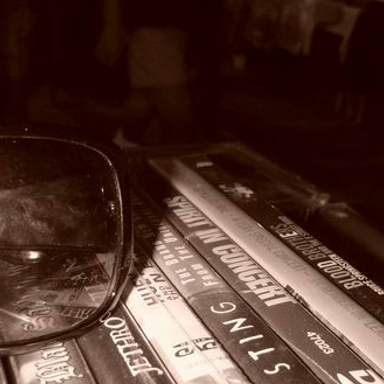

In [3]:
img, label = data_val[41809]
# Undo imagenet norm, then permute dims. 
img = unnorm(img)
img = img.permute(1,2,0)
img = np.array(img*255).astype(np.uint8)
img = Image.fromarray(img)
img

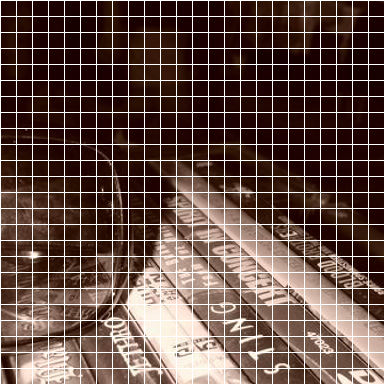

In [4]:
np_img = np.array(img)
patch_size = 16
color = (255, 255, 255)  # Blue color
thickness = 1
image_with_grid = np_img.copy()
# Convert to 3-channel if the input is grayscale
if len(image_with_grid.shape) == 2:
    image_with_grid = cv2.cvtColor(image_with_grid, cv2.COLOR_GRAY2BGR)
# Get image dimensions
height, width = image_with_grid.shape[:2]

# Draw vertical lines
for x in range(0, width, patch_size):
    cv2.line(image_with_grid, (x, 0), (x, height), color, thickness)

# Draw horizontal lines
for y in range(0, height, patch_size):
    cv2.line(image_with_grid, (0, y), (width, y), color, thickness)

# Display image with grid
img = Image.fromarray(image_with_grid)
img

In [6]:
import torch

def compute_patch_entropy_vectorized(image, patch_sizes=[16, 32], bins=512, pad_value=1e6):
    """
    Compute entropy maps for multiple patch sizes in the input image using vectorized operations.
    
    Args:
        image: torch.Tensor of shape (C, H, W) or (H, W) with values in range [0, 255]
        patch_sizes: list of patch sizes (default: [16, 32])
        bins: number of bins for histogram (default: 512)
        pad_value: high entropy value to pad incomplete patches with (default: 1e6)
    
    Returns:
        entropy_maps: dict containing torch.Tensor entropy maps for each patch size
    """
    if len(image.shape) == 3:
        # Convert to grayscale if image is RGB
        if image.shape[0] == 3:
            image = 0.2989 * image[0] + 0.5870 * image[1] + 0.1140 * image[2]
        else:
            image = image[0]
    
    entropy_maps = {}
    H, W = image.shape

    for patch_size in patch_sizes:
        num_patches_h = (H + patch_size - 1) // patch_size  # Round up
        num_patches_w = (W + patch_size - 1) // patch_size  # Round up

        # Pad image to ensure it fits into patches cleanly
        pad_h = num_patches_h * patch_size - H
        pad_w = num_patches_w * patch_size - W
        padded_image = torch.nn.functional.pad(image, (0, pad_w, 0, pad_h), mode='constant', value=0)

        # Unfold the image into patches
        patches = padded_image.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
        patches = patches.reshape(num_patches_h * num_patches_w, -1)

        # Compute histograms for all patches
        bin_edges = torch.linspace(0, 255, bins + 1, device=image.device)
        histograms = torch.stack([torch.histc(patch, bins=bins, min=0, max=255) for patch in patches])

        # Normalize histograms to get probabilities
        probabilities = histograms / (patch_size * patch_size)

        # Compute entropy: -sum(p * log2(p)), avoiding log(0)
        epsilon = 1e-10
        entropy = -torch.sum(probabilities * torch.log2(probabilities + epsilon), dim=1)

        # Reshape back to spatial dimensions
        entropy_map = entropy.reshape(num_patches_h, num_patches_w)

        # Assign a high value to padded regions
        if pad_h > 0:
            entropy_map[-1, :] = pad_value  # High entropy at bottom row
        if pad_w > 0:
            entropy_map[:, -1] = pad_value  # High entropy at right column

        entropy_maps[patch_size] = entropy_map

    return entropy_maps

# output_grid = compute_patch_entropy_vectorized(torch.tensor(np_img).permute(2, 0, 1), patch_sizes=[16, 32])
# output_grid16 = output_grid[16]
# # PLot outpu_grid as a heatmap
# plt.imshow(output_grid16, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.show()

In [7]:
# def visualize_adaptive_patches_with_splits(image, entropy_map, T, patch_size=64):
#     """
#     Visualize patches on the image. 
#     - Low-entropy patches are drawn as is.
#     - High-entropy patches are split into 4 smaller patches and visualized.

#     Args:
#         image: torch.Tensor of shape (C, H, W) or (H, W) with values in range [0, 255].
#         entropy_map: Precomputed torch.Tensor of shape (H//patch_size, W//patch_size) with entropy values.
#         T: Threshold for entropy to decide patch handling.
#         patch_size: Initial patch size (default: 64).

#     Returns:
#         visualized_image: numpy.ndarray of the original image with patch boundaries drawn.
#     """
#     # Ensure input image is in color
#     if len(image.shape) == 2:  # Grayscale input
#         image = image.unsqueeze(0).repeat(3, 1, 1)  # Replicate channels
#     elif image.shape[0] == 1:  # Single-channel grayscale
#         image = image.repeat(3, 1, 1)

#     # Prepare the output image for visualization
#     image_np = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
#     image_np = (image_np / image_np.max() * 255).astype(np.uint8)

#     H, W = image.shape[1], image.shape[2]
#     num_patches_h, num_patches_w = entropy_map.shape

#     num_large_patches = (entropy_map > T).sum()
#     num_small_patches = (entropy_map <= T).sum() * 4
#     num_orig_patches = entropy_map.shape[0] * entropy_map.shape[1] * 4
#     num_new_patches = int(num_large_patches + num_small_patches)
#     # print(f"Number of large patches: {num_large_patches}")
#     # print(f"Number of small patches: {num_small_patches}")
#     # print("Original n patches: ", num_orig_patches)
#     # print("New n patches: ", num_new_patches)
#     # print("rewduction: ", (num_orig_patches - num_new_patches) / num_orig_patches)
#     # Iterate through the entropy map to handle patches
#     num_patches = 0
#     for i in range(num_patches_h):
#         for j in range(num_patches_w):
#             y, x = i * patch_size, j * patch_size
#             if y + patch_size > H or x + patch_size > W:
#                 continue  # Skip patches that exceed image boundaries

#             if entropy_map[i, j] < T:
#                 # Low-entropy patch: draw the original patch
#                 cv2.rectangle(image_np, (x, y), (x + patch_size - 1, y + patch_size - 1), (255, 255, 255), 1)
#                 num_patches += 1
#             else:
#                 # High-entropy patch: split into 4 smaller patches
#                 half_patch = patch_size // 2
#                 for dy in [0, half_patch]:
#                     for dx in [0, half_patch]:
#                         sub_y, sub_x = y + dy, x + dx
#                         if sub_y + half_patch <= H and sub_x + half_patch <= W:
#                             cv2.rectangle(image_np, (sub_x, sub_y), (sub_x + half_patch - 1, sub_y + half_patch - 1), 
#                                           (255, 255, 255), 1)
#                             num_patches += 1
#     print("New patches: ", num_patches)
#     print("Original patches:", num_orig_patches)
#     print("Reduced patch count by {:.1f}%".format(100 * (num_orig_patches - num_patches) / num_orig_patches))

#     return image_np

# def count_patches(entropy_map, threshold):
#     """
#     Count patches based on entropy threshold.
#     Patches with entropy < threshold are kept at original size.
#     Others are split into 4 smaller patches.
#     """
#     num_patches = torch.sum(entropy_map < threshold).item()  # Count patches below threshold
#     num_splits = torch.sum(entropy_map >= threshold).item()  # Count patches that will be split
#     return num_patches + (num_splits * 4)  # Each split creates 4 smaller patches


In [8]:
# threshold = 5  # Adjust threshold for entropy
# initial_patch_size = 32

# torch_img = torch.tensor(np_img).permute(2, 0, 1)
# print(torch_img.shape)

# # entropy_map = compute_patch_entropy_vectorized(torch_img, patch_sizes=[initial_patch_size], bins=256)
# # patch_count = count_patches(entropy_map[32], threshold)
# # print("Patch count: ", patch_count)
# # visualized_image = visualize_adaptive_patches_with_splits(torch_img, 
# #     entropy_map[32], 
# #     T=threshold, 
# #     patch_size=initial_patch_size)

# # # Visualize the adaptive patches

# # img = Image.fromarray(visualized_image)
# # img

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import color, img_as_ubyte, data
# from skimage.filters.rank import entropy
# from skimage.morphology import disk

# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import color, img_as_ubyte, data
# from skimage.filters.rank import entropy
# from skimage.morphology import disk

# def partition_image_by_entropy(img_rgb, patch_sizes=(16, 32, 64), entropy_disk_radius=7):
#     """
#     Partition an RGB image into non-overlapping square patches with sizes chosen based on local entropy.
    
#     Parameters:
#       img_rgb : np.array of shape (H, W, 3)
#           Input RGB image.
#       patch_sizes : tuple of ints
#           Allowed patch sizes (square patches). Convention:
#             - highest entropy -> smallest patch (patch_sizes[0])
#             - medium entropy   -> patch_sizes[1]
#             - lowest entropy   -> largest patch (patch_sizes[2])
#       entropy_disk_radius : int
#           Radius of disk used for computing local entropy.
    
#     Returns:
#       patches : list of tuples (i, j, ps)
#           Each tuple defines a square patch starting at row i, column j, with side length ps.
#       patch_map : 2D np.array of shape (H, W)
#           An array where each pixel’s value is the patch size assigned based on local entropy.
#       ent_map : 2D np.array of shape (H, W)
#           The local entropy map.
#     """
#     # Convert RGB to grayscale for entropy computation.
#     img_gray = color.rgb2gray(img_rgb)
#     # Convert to uint8 (required by skimage.rank.entropy)
#     img_gray_uint8 = img_as_ubyte(img_gray)
    
#     # Compute the local entropy using a disk-shaped structuring element.
#     ent_map = entropy(img_gray_uint8, disk(entropy_disk_radius))
    
#     # Determine thresholds based on percentiles.
#     thr_low = np.percentile(ent_map, 33)
#     thr_high = np.percentile(ent_map, 66)
    
#     H, W = img_gray_uint8.shape
#     # Build a patch size map: each pixel gets a suggested square patch size.
#     patch_map = np.full((H, W), patch_sizes[2], dtype=np.int32)  # default: largest patch
#     patch_map[ent_map > thr_low] = patch_sizes[1]    # moderate entropy -> medium patch
#     patch_map[ent_map > thr_high] = patch_sizes[0]   # high entropy -> smallest patch

#     # Greedy, raster-scan partitioning into non-overlapping square patches.
#     visited = np.zeros((H, W), dtype=bool)
#     patches = []
#     for i in range(H):
#         for j in range(W):
#             if visited[i, j]:
#                 continue
#             # Determine the patch size (square patch) for this region.
#             ps = patch_map[i, j]
#             # Ensure the patch stays within image bounds.
#             ps = min(ps, H - i, W - j)
#             patches.append((i, j, ps))
#             # Mark the square patch as visited.
#             visited[i:i+ps, j:j+ps] = True

#     return patches, patch_map, ent_map

# def visualize_partitions(img_rgb, patches):
#     """
#     Visualize the RGB image with partition boundaries overlaid.
    
#     Parameters:
#       img_rgb : np.array of shape (H, W, 3)
#           The input RGB image.
#       patches : list of tuples (i, j, ps)
#           List of square patches as returned by partition_image_by_entropy.
#     """
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.imshow(img_rgb)
#     for (i, j, ps) in patches:
#         # Draw a red rectangle for each square patch.
#         rect = plt.Rectangle((j, i), ps, ps, edgecolor='red', facecolor='none', linewidth=1.5)
#         ax.add_patch(rect)
#     ax.set_title("Image with Square Partition Boundaries")
#     ax.axis('off')
#     plt.show()

# patches, patch_map, ent_map = partition_image_by_entropy(np_img, patch_sizes=(16, 32, 64), entropy_disk_radius=7)
    
# print("Number of patches:", len(patches))

# # Visualize the entropy map and patch size map.
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# im0 = axes[0].imshow(ent_map, cmap='inferno')
# axes[0].set_title("Local Entropy Map")
# plt.colorbar(im0, ax=axes[0])

# im1 = axes[1].imshow(patch_map, cmap='viridis')
# axes[1].set_title("Patch Size Map")
# plt.colorbar(im1, ax=axes[1])

# #visualize_partitions(img_rgb, patches)

In [10]:
def select_patches_by_threshold(entropy_maps, threshold):
    """
    Given a threshold and a dictionary of entropy maps that includes
    both 32x32 and 16x16 patch sizes, this function does the following:
      1. Looks at the 32x32 map and selects all patches below `threshold`.
      2. Marks those selected 32x32 patches in mask32 with a 1 (others with 0).
      3. For each selected 32x32 patch, mark the corresponding region (2x2 block)
         in the 16x16 mask to 0. (So, those 16x16 patches in that region won't be used.)
      4. The remaining 16x16 patches are marked as 1.
      5. Return the masked values for each entropy map (patches32, patches16)
         along with the masks themselves (mask32, mask16).
    
    Args:
        entropy_maps (dict): Must contain keys 16 and 32, mapping to
            torch.Tensor entropy maps:
            - entropy_maps[16]: shape (H16, W16)
            - entropy_maps[32]: shape (H32, W32)
        threshold (float): The threshold below which 32x32 patches are "selected"

    Returns:
        patches32 (torch.Tensor): 32x32 entropy map masked by mask32
        patches16 (torch.Tensor): 16x16 entropy map masked by mask16
        mask32    (torch.Tensor): 0/1 mask for 32x32 patches
        mask16    (torch.Tensor): 0/1 mask for 16x16 patches
    """
    # Extract the 16x16 and 32x32 maps
    entropy_16 = entropy_maps[16]
    entropy_32 = entropy_maps[32]

    # 1) Create the 32x32 mask by thresholding
    mask32 = (entropy_32 < threshold).float()  # 1 where selected, else 0

    # 2) Create an all-ones mask for the 16x16 map
    mask16 = torch.ones_like(entropy_16, dtype=torch.float, device=entropy_16.device)

    # For each selected 32x32 patch, zero-out the corresponding 2x2 block in the 16x16 mask
    # Because each 32-pixel patch in the image corresponds to 2 x (16-pixel) patches in the smaller map
    H32, W32 = mask32.shape
    for i in range(H32):
        for j in range(W32):
            if mask32[i, j] == 1:
                # Each 32x32 patch covers a 2x2 area in the 16x16 patch map
                i_start, i_end = i * 2, i * 2 + 2
                j_start, j_end = j * 2, j * 2 + 2
                # Make sure we don't go out of bounds if the shapes don't line up perfectly
                i_end = min(i_end, mask16.shape[0])
                j_end = min(j_end, mask16.shape[1])
                mask16[i_start:i_end, j_start:j_end] = 0

    # 3) Multiply the original entropy maps by their masks to get the "selected" patches
    patches32 = entropy_32 * mask32
    patches16 = entropy_16 * mask16

    return mask32, mask16

def visualize_selected_patches_cv2(
    image_tensor, 
    mask32, mask16, 
    patch_size_32=32, 
    patch_size_16=16, 
    color=(255, 255, 255),  # BGR in OpenCV, but white is the same in BGR or RGB
    thickness=1
):
    """
    Draw rectangles (using cv2) where masks are 1 for both 32x32 and 16x16 patches,
    then return a PIL Image.

    Args:
        image_tensor   (torch.Tensor): Grayscale or RGB image of shape (H, W) or (C, H, W).
        mask32         (torch.Tensor): 0/1 mask for 32x32 patches, shape (H32, W32).
        mask16         (torch.Tensor): 0/1 mask for 16x16 patches, shape (H16, W16).
        patch_size_32               : Integer size of each 32x32 patch in pixel space.
        patch_size_16               : Integer size of each 16x16 patch in pixel space.
        color          (tuple)      : BGR color for rectangle outlines (default white).
        thickness      (int)        : Thickness of the rectangle outline.

    Returns:
        annotated_image_pil (PIL.Image): The original image with drawn rectangles (in white).
    """

    # 1. Convert the image tensor to a NumPy array for OpenCV
    if image_tensor.ndim == 3:
        # If image_tensor is (C, H, W) with channels first
        if image_tensor.shape[0] in [1, 3]:
            image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        else:
            # Already (H, W, C)
            image_np = image_tensor.cpu().numpy()
    else:
        # (H, W) -> expand dimension for single-channel (H, W, 1)
        image_np = image_tensor.cpu().numpy()
        # Expand to 3 channels to draw colored rectangles
        image_np = np.stack([image_np]*3, axis=-1)

    # Convert to uint8 if needed
    if image_np.dtype != np.uint8:
        image_np = image_np.astype(np.uint8)

    # 2. Draw rectangles using cv2
    annotated_np = image_np.copy()

    # Draw 32x32 patches where mask32 == 1
    H32, W32 = mask32.shape
    for i in range(H32):
        for j in range(W32):
            if mask32[i, j] == 1:
                top_left = (j * patch_size_32, i * patch_size_32)
                bottom_right = (
                    top_left[0] + patch_size_32 - 1,
                    top_left[1] + patch_size_32 - 1,
                )
                cv2.rectangle(annotated_np, top_left, bottom_right, color, thickness)

    # Draw 16x16 patches where mask16 == 1
    H16, W16 = mask16.shape
    for i in range(H16):
        for j in range(W16):
            if mask16[i, j] == 1:
                top_left = (j * patch_size_16, i * patch_size_16)
                bottom_right = (
                    top_left[0] + patch_size_16 - 1,
                    top_left[1] + patch_size_16 - 1,
                )
                cv2.rectangle(annotated_np, top_left, bottom_right, color, thickness)

    # 3. Convert back to PIL image
    #    - If your image was originally RGB, OpenCV expects BGR, but since color is white
    #      the result is the same. If you had a different color, you might want to flip channels.
    #    - For pure white rectangles, you can skip channel flipping, as (255,255,255) is the same in RGB/BGR.
    annotated_image_pil = Image.fromarray(annotated_np)

    return annotated_image_pil


torch_img = torch.tensor(np_img).permute(2, 0, 1)
print(torch_img.shape)

threshold = 6.5
entropy_maps = compute_patch_entropy_vectorized(torch_img, patch_sizes=[16, 32], bins=256)
# 1) Select patches
mask32, mask16 = select_patches_by_threshold(
    entropy_maps, threshold
)

# 2) Visualize the selected patches
print("Visualizing...")
annotated_pil = visualize_selected_patches_cv2(
    torch_img, 
    mask32, 
    mask16,
    patch_size_32=32,
    patch_size_16=16,
    color=(255, 255, 255),
    thickness=1
)



torch.Size([3, 384, 384])
Visualizing...


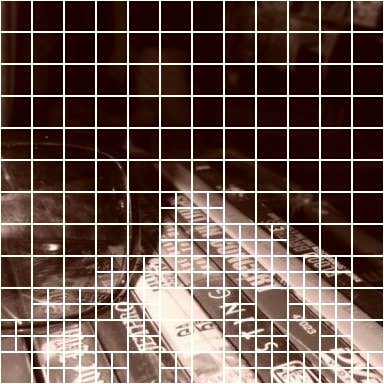

In [11]:
annotated_pil